In [11]:
import numpy as np
%matplotlib inline 
#notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FormatStrFormatter)
from scipy.optimize import fsolve
import pandas as pd
import warnings
import pickle
import functions_binding_model as bfunc 
import plotly as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected=True)

np.seterr(all = 'raise')
warnings.filterwarnings('error')

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex = True)
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

## McGhee-von Hippel-Manning model

In [2]:
Na            = 34
Nb            = 0.5*Na
lb            = 0.7                 # Bjerrum length (nm) for SPC/E water at 300K is 0.78
R             = 1.8                 # dPGS radius nm
alpha         = 1.36                # eps / eps* = (T* / T)^alpha
vol_init      = 1.43                # mililitres initial titration volume
vol_injection = 8.00e-3             # mililitres injection volume
gas_constant  = 8.3144598           # J/K/mol
Temperature   = 300                 # K
std_volume    = 0.6022140857        # Standard volume L/mol

cal_per_mol_to_J_per_mol  = 4.184
J_per_mol_to_kT           = gas_constant*Temperature
cal_per_mol_to_kT         = cal_per_mol_to_J_per_mol / J_per_mol_to_kT

def kappa(I_num_per_nm3):
    #I_num_per_nm3 = I_mmolar * std_volume / 1000
    return (8 * np.pi * lb * I_num_per_nm3 )**(0.5) 


def zeta(I_num_per_nm3):
    return  Na * lb / R / (1 + R*kappa(I_num_per_nm3)) 


def chi(I_num_per_nm3):
    return 0.5 * zeta(I_num_per_nm3) * (1 + 1/(1 + R*kappa(I_num_per_nm3))) * (alpha - 1)


def ionic_strength(injection_number, I_buffer, conc_mg_injectant):
    
    '''I_buffer = combined ionic strength of MOPS and NaCl I_nacl
       = ionic strength of NaCl'''
    
    conc_mg_solution = conc_mg_injectant * injection_number * vol_injection\
                       / (vol_init + injection_number*vol_injection)
    
    I_mgcl2 = 3*conc_mg_solution
    
    I_total = I_buffer + I_mgcl2
    
    return I_total


def running_avg(x, neighbours = 2):
    return np.convolve(x, np.ones((neighbours,))/neighbours, mode='valid')

In [3]:
data = pd.read_csv("cg-g2-bound-counterions.csv", sep = ',', index_col = None)

print(data)

   conc  mg_bound  mg_total  na_bound  na_total
0     0      0.00         0      13.2      2438
1     1      2.25        16      10.2      2438
2     3      3.98        48       8.4      2438
3     5      4.88        61       7.3      2438
4    10      6.14       162       6.3      2438
5    15      6.72       243       5.7      2438


## Getting ITC data

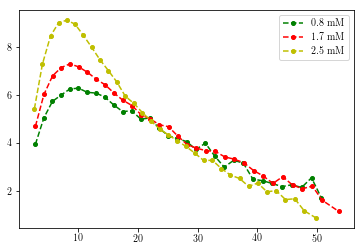

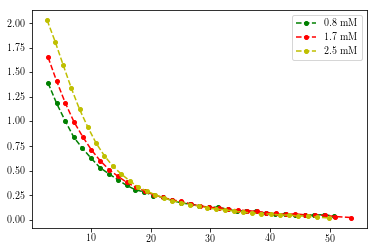

In [12]:
itc_data = pd.read_csv("/home/rohit/google-drive/magnesium/itc/data.csv",\
                       sep = ',', index_col = None)


xb_0_8mM, xb_1_7mM, xb_2_5mM = np.array(itc_data["ratio_0_8mM"].dropna()),\
                               np.array(itc_data["ratio_1_7mM"]),\
                               np.array(itc_data["ratio_2_5mM"])

q_0_8mM, q_1_7mM, q_2_5mM    = np.array(itc_data["q_0_8mM"].dropna()) * cal_per_mol_to_J_per_mol,\
                               np.array(itc_data["q_1_7mM"]) * cal_per_mol_to_J_per_mol,\
                               np.array(itc_data["q_2_5mM"]) * cal_per_mol_to_J_per_mol

q_0_8mM_per_mg, q_1_7mM_per_mg, q_2_5mM_per_mg = q_0_8mM / (gas_constant*Temperature),\
                                                 q_1_7mM / (gas_constant*Temperature),\
                                                 q_2_5mM / (gas_constant*Temperature)

q_0_8mM_per_d, q_1_7mM_per_d, q_2_5mM_per_d    = q_0_8mM_per_mg * xb_0_8mM ,\
                                                 q_1_7mM_per_mg * xb_1_7mM ,\
                                                 q_2_5mM_per_mg * xb_2_5mM


plt.plot(xb_0_8mM, q_0_8mM_per_d,\
         marker = 'o', linestyle = '--', markersize = 4, \
         label = '0.8 mM', color = 'g')

plt.plot(xb_1_7mM, q_1_7mM_per_d,\
         marker = 'o', linestyle = '--', markersize = 4, \
         label = '1.7 mM', color = 'r')

plt.plot(xb_2_5mM, q_2_5mM_per_d,\
         marker = 'o', linestyle = '--', markersize = 4, \
         label = '2.5 mM', color = 'y')

plt.legend()
plt.show()


plt.plot(xb_0_8mM, q_0_8mM_per_mg,\
         marker = 'o', linestyle = '--', markersize = 4, \
         label = '0.8 mM', color = 'g')

plt.plot(xb_1_7mM, q_1_7mM_per_mg,\
         marker = 'o', linestyle = '--', markersize = 4, \
         label = '1.7 mM', color = 'r')

plt.plot(xb_2_5mM, q_2_5mM_per_mg,\
         marker = 'o', linestyle = '--', markersize = 4, \
         label = '2.5 mM', color = 'y')

plt.legend()
plt.show()

In [151]:
!ls -lrth solution_with_*

-rw------- 1 rohit rohit 5.7K May 13 14:18 solution_with_errormg_0_8mM_ka_-9_0_kb_-5_25_reff_0.7_1.8.p
-rw------- 1 rohit rohit  36K May 13 14:18 solution_with_error_mg_0_8mM_ka_-9_0_kb_-5_25_reff_0.7_1.8.p
-rw------- 1 rohit rohit  37K May 13 20:35 solution_with_error_mg_2_5mM_ka_-9_0_kb_-5_25_reff_0.7_1.8.p
-rw------- 1 rohit rohit  37K May 13 20:35 solution_with_error_mg_1_7mM_ka_-9_0_kb_-5_25_reff_0.7_1.8.p


## Solving 

In [7]:
##sol, df = func.open_and_assign("solution_mg_1_7mM_ka_-15_0_kb_-10_25_reff_0.793_0.986.p")
sol, df = bfunc.open_and_assign("solution_mg_0_8mM_ka_-10_10_kb_-10_20_reff_0.7_1.4.p")
##sol, df = func.open_and_assign("solution_mg_0_8mM_ka_-10_10_kb_-10_20_reff_0.7_1.4.p")
##sol, df = func.open_and_assign("solution_mg_2_5mM_ka_-10_0_kb_-10_20_reff_0.729_0.827.p")

#print(df['error'], df.index)
'''
print(sol['rel_error'],2*'\n',\
      sol['ka0'], 2*'\n',\
      sol['kb0'], 2*'\n',\
      sol['theta_a'], 2*'\n',\
      sol['theta_b'], 2*'\n',\
      sol['q_per_mg'], 2*'\n',
      df) 
'''      
'''
decrease reff
vary xb_start
chi array last element
try without mixing entropy
try first chi element
'''

'\ndecrease reff\nvary xb_start\nchi array last element\ntry without mixing entropy\ntry first chi element\n'

In [8]:
layout = go.Layout(
    title = 'error vs reff',
    yaxis = dict(
        title = '% error'
    ),
    xaxis = dict(
        title = 'reff'
    )
)

trace = go.Scatter(
    x = df.index,
    y = df['error']-30,
    mode = 'lines'
)

fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig)

'\n#plt.plot(keylist[3:-2], error_list_1_7[3:-2])\n#plt.plot(keylist[3:-8], error_list_2_5[3:-8])\n'

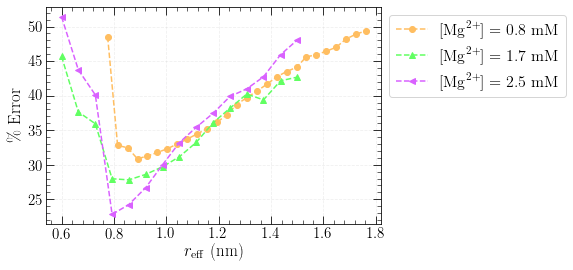

In [97]:
sol_0_8 = bfunc.open_and_assign("solution_with_error_mg_0_8mM_ka_-9_0_kb_-5_25_reff_0.7_1.8.p")
sol_1_7, df_1_7 = bfunc.open_and_assign("solution_mg_1_7mM_ka_-10_30_kb_-10_30_reff_0.6_1.5.p")
sol_2_5, df_2_5 = bfunc.open_and_assign("solution_mg_2_5mM_ka_-10_30_kb_-10_30_reff_0.6_1.5.p")

error_list_0_8 = []

for key in sol_0_8.keys():
    error_list_0_8.append(sol_0_8[key]['error'])
    #error_list_1_7.append(sol_1_7[key]['error'])
    #error_list_2_5.append(sol_2_5[key]['error'])
    
error_list_0_8 = np.concatenate(error_list_0_8, axis=None)
#error_list_1_7 = np.concatenate(error_list_1_7, axis=None)
#error_list_2_5 = np.concatenate(error_list_2_5, axis=None)

keylist = list(sol_0_8.keys())

fig = plt.figure() #figsize = [4., 4.]
ax  = fig.add_subplot(111)

plt.plot(keylist[2:-1], error_list_0_8[2:-1], marker = 'o', markersize = 6,\
         linestyle = '--', color = '#FFBE61',\
         label = r"$\displaystyle [{\rm Mg^{2+}}] = 0.8$" ' mM')
plt.plot(df_1_7['error'], marker = '^', markersize = 6,\
         linestyle = '--', color = '#61FF62',\
         label = r"$\displaystyle [{\rm Mg^{2+}}] = 1.7$" ' mM')
plt.plot(df_2_5['error'], marker = '<', markersize = 6,\
         linestyle = '--', color = '#D961FF',\
         label = r"$\displaystyle [{\rm Mg^{2+}}] = 2.5$" ' mM')

# Custom x axis
ax.tick_params(labelsize = 15)
plt.grid(True)
ax.tick_params(which = 'major', direction = 'in', length = 8, top = True, right = True)
ax.tick_params(which = 'minor', direction = 'in', length = 4, top = True, right = True)

ax.tick_params(labelsize = 15, grid_alpha = 0.2, grid_linestyle = '--')
ax.set_axisbelow(True)

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5)) 
ax.xaxis.set_major_locator(MultipleLocator(.2))
ax.xaxis.set_minor_locator(AutoMinorLocator(5)) 

xlabel = r"$\displaystyle r_{\rm eff}$" ' (nm)'
ylabel = r"$\displaystyle \%$" ' Error'
plt.xlabel(xlabel, fontsize = 17)
plt.ylabel(ylabel, fontsize = 17)
plt.legend(fontsize = 16, loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.plot()

# Show graphic
#plt.show()
file_save_address = '/home/rohit/google-drive/magnesium/mg-netz/report-retreat/images-mg/'
#plt.savefig(file_save_address + 'error_vs_reff.png',\
             #bbox_inches = 'tight', dpi = 200)

'''
#plt.plot(keylist[3:-2], error_list_1_7[3:-2])
#plt.plot(keylist[3:-8], error_list_2_5[3:-8])
'''

In [4]:
data_0_8mM_itc = bfunc.get_exp_data('/home/rohit/google-drive/magnesium/itc/data.csv',\
                                    'mg_0_8mM')
data_1_7mM_itc = bfunc.get_exp_data('/home/rohit/google-drive/magnesium/itc/data.csv',\
                                    'mg_1_7mM')
data_2_5mM_itc = bfunc.get_exp_data('/home/rohit/google-drive/magnesium/itc/data.csv',\
                                    'mg_2_5mM')

q_0_8mM_itc = data_0_8mM_itc['q_array']
xb_0_8mM_itc= data_0_8mM_itc['xb_array']
q_1_7mM_itc = data_1_7mM_itc['q_array']
xb_1_7mM_itc= data_1_7mM_itc['xb_array']
q_2_5mM_itc = data_2_5mM_itc['q_array']
xb_2_5mM_itc= data_2_5mM_itc['xb_array']

sol_0_8, df_0_8 = bfunc.open_and_assign("solution_mg_0_8mM_ka_-9_0_kb_5_25_reff_0.85_1.029.p")
sol_1_7, df_1_7 = bfunc.open_and_assign("solution_mg_1_7mM_ka_-15_0_kb_-10_25_reff_0.793_0.986.p")
sol_2_5, df_2_5 = bfunc.open_and_assign("solution_mg_2_5mM_ka_-10_0_kb_-10_20_reff_0.729_0.827.p")

print(df_2_5)


print(sol_0_8['rel_error'], sol_1_7['rel_error'], sol_2_5['rel_error'])
print(np.exp(sol_0_8['ka0']), np.exp(sol_1_7['ka0']), np.exp(sol_2_5['ka0']))
print(np.exp(sol_0_8['kb0']), np.exp(sol_1_7['kb0']), np.exp(sol_2_5['kb0']))

       error        ka0        kb0
0.729  39.62 -10.000000  -9.699248
0.736  23.71  -9.949749  18.345865
0.743  39.13 -10.000000  -9.699248
0.750  23.20  -9.899497  17.744361
0.757  22.81  -9.899497  17.518797
0.764  22.82 -10.000000  17.218045
0.771  22.66 -10.000000  17.218045
0.778  22.70  -9.899497  17.368421
0.785  22.64  -9.899497  17.218045
0.792  22.69  -9.849246  16.015038
0.799  22.74  -9.899497  16.090226
0.806  22.86  -9.648241  17.368421
0.813  23.01  -9.497487  17.443609
0.820  23.13  -9.396985  17.443609
0.827  23.55  -9.095477  17.669173
[30.67466] [27.59817] [22.64]
[0.00161476] [0.00036538] [5.01999018e-05]
[7.17763364e+09] [1.84856003e+08] [30040142.02710501]


[30.67466] [27.59817] [22.64]
[0.00161476] [0.00036538] [5.01999018e-05]
[7.17763364e+09] [1.84856003e+08] [30040142.02710501]


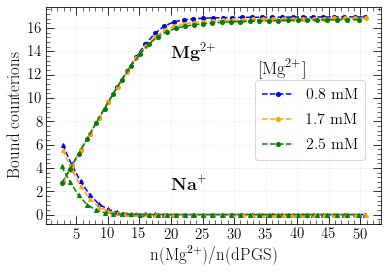

In [167]:
fig = plt.figure() #figsize = [4., 4.]
ax  = fig.add_subplot(111)

plt.plot(xb_0_8mM_itc[:-1], Nb*sol_0_8['theta_b'][0], marker = 'o', markersize = 4,\
         linestyle = '--', color = 'blue',\
         label = r"0.8 mM")
plt.plot(xb_0_8mM_itc[:-1], Na*sol_0_8['theta_a'][0], marker = '^', markersize = 4,\
         linestyle = '--', color = 'blue',\
         )

plt.plot(xb_1_7mM_itc[:-1], Nb*sol_1_7['theta_b'][0][:-1], marker = 'o',\
         markersize = 4, linestyle = '--',\
         label = r"1.7 mM", color = 'orange')
plt.plot(xb_1_7mM_itc[:-1], Na*sol_1_7['theta_a'][0][:-1], marker = '^',\
         markersize = 4, linestyle = '--',\
         color = 'orange')

plt.plot(xb_2_5mM_itc[:], Nb*sol_2_5['theta_b'][0], marker = 'o', markersize = 4,\
         linestyle = '--', color = 'green',\
         label = r"2.5 mM")
plt.plot(xb_2_5mM_itc[:], Na*sol_2_5['theta_a'][0], marker = '^', markersize = 4,\
         linestyle = '--', color = 'green'\
         )


# Custom x axis
ax.tick_params(labelsize = 15)
plt.grid(True)
ax.tick_params(which = 'major', direction = 'in', length = 8, top = True, right = True)
ax.tick_params(which = 'minor', direction = 'in', length = 4, top = True, right = True)

ax.tick_params(labelsize = 15, grid_alpha = 0.2, grid_linestyle = '--')
ax.set_axisbelow(True)

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5)) 
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5)) 

xlabel = 'n(Mg' r"$\displaystyle ^{2+}$" ')/n(dPGS)'
ylabel = r"Bound counterions"
#ylabel = r"$\displaystyle \Delta Q/c_{\rm B}^0 V_0$" ' (' r"$\displaystyle k_{\rm B}T/$" 'Mg'\
         #r"$\displaystyle ^{2+}$" ' ion)'
plt.xlabel(xlabel, fontsize = 17)
plt.ylabel(ylabel, fontsize = 17)
plt.legend(fontsize = 16, loc='upper left', bbox_to_anchor=(.6,.7), ncol=1)
#plt.legend(fontsize = 16)
plt.text(34, 12, r"[Mg$\displaystyle ^{2+}$]" , fontsize = 18)
plt.text(20, 13.5, r"\bf{Mg}$\displaystyle ^{2+}$" , fontsize = 18)
plt.text(20, 2, r"\bf{Na}$\displaystyle ^{+}$" , fontsize = 18)
#plt.text(12, 1.5, r"\bf{2.5 mM Mg}$\displaystyle^{2+}$" , fontsize = 18)

# Show graphic
#plt.show()
file_save_address = '/home/rohit/google-drive/magnesium/mg-netz/report-retreat/images-mg/'
#plt.savefig(file_save_address + 'bound_ions_model.png',\
            #bbox_inches = 'tight', dpi = 200)

## Calculating free ion fraction from ITC curves

'\nfrac[0] = 0\nfrac[1] = 1- x[0]/x[1]*(q[1]/q[0] + 1)\n\nfor i in range(1,len(q)-1):\n    \n    frac[i+1] = 1 - (x[i]*(1-frac[i])*(q[i+1]/q[i] + 1) - x[i-1]*(1-frac[i-1])*q[i+1]/q[i])/x[i+1]\n\nplt.plot(frac)\nprint(frac)\n'

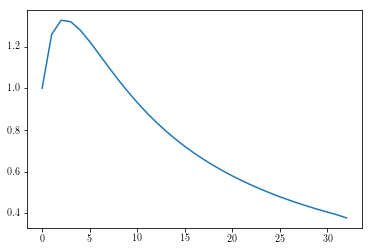

In [29]:
itc_data = bfunc.open_and_assign("itc_data.p")
#print(itc_data)

x = itc_data["ratio_2_5mM"]
q  = itc_data["q_2_5mM"]

frac = np.zeros(len(q))
frac[0] = 1
frac[1] = x[0]/x[1]*(q[1]/q[0] + 1)

for i in range(1,len(q)-1):
    
    frac[i+1] = (x[i]*frac[i]*(q[i+1]/q[i] + 1) - x[i-1]*frac[i-1]*q[i+1]/q[i])/x[i+1]
plt.plot(frac)

'''
frac[0] = 0
frac[1] = 1- x[0]/x[1]*(q[1]/q[0] + 1)

for i in range(1,len(q)-1):
    
    frac[i+1] = 1 - (x[i]*(1-frac[i])*(q[i+1]/q[i] + 1) - x[i-1]*(1-frac[i-1])*q[i+1]/q[i])/x[i+1]

plt.plot(frac)
print(frac)
'''

'\nplt.plot(xb_0_8mM_itc[:-1], Na*sol_0_8[\'theta_a\'][0], marker = \'^\', markersize = 4,         linestyle = \'--\', color = \'blue\',         )\n\nplt.plot(xb_1_7mM_itc[:-1], Nb*sol_1_7[\'theta_b\'][0][:-1], marker = \'o\',         markersize = 4, linestyle = \'--\',         label = r"1.7 mM", color = \'orange\')\nplt.plot(xb_1_7mM_itc[:-1], Na*sol_1_7[\'theta_a\'][0][:-1], marker = \'^\',         markersize = 4, linestyle = \'--\',         color = \'orange\')\n\nplt.plot(xb_2_5mM_itc[:], Nb*sol_2_5[\'theta_b\'][0], marker = \'o\', markersize = 4,         linestyle = \'--\', color = \'green\',         label = r"2.5 mM")\nplt.plot(xb_2_5mM_itc[:], Na*sol_2_5[\'theta_a\'][0], marker = \'^\', markersize = 4,         linestyle = \'--\', color = \'green\'         )\n'

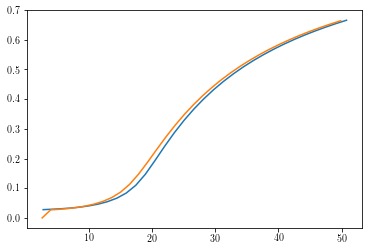

In [6]:
plt.plot(xb_0_8mM_itc[:-1], 1-Nb*sol_0_8['theta_b'][0]/xb_0_8mM_itc[:-1])
plt.plot(xb_2_5mM_itc     , 1-Nb*sol_2_5['theta_b'][0]/xb_2_5mM_itc)

'''
plt.plot(xb_0_8mM_itc[:-1], Na*sol_0_8['theta_a'][0], marker = '^', markersize = 4,\
         linestyle = '--', color = 'blue',\
         )

plt.plot(xb_1_7mM_itc[:-1], Nb*sol_1_7['theta_b'][0][:-1], marker = 'o',\
         markersize = 4, linestyle = '--',\
         label = r"1.7 mM", color = 'orange')
plt.plot(xb_1_7mM_itc[:-1], Na*sol_1_7['theta_a'][0][:-1], marker = '^',\
         markersize = 4, linestyle = '--',\
         color = 'orange')

plt.plot(xb_2_5mM_itc[:], Nb*sol_2_5['theta_b'][0], marker = 'o', markersize = 4,\
         linestyle = '--', color = 'green',\
         label = r"2.5 mM")
plt.plot(xb_2_5mM_itc[:], Na*sol_2_5['theta_a'][0], marker = '^', markersize = 4,\
         linestyle = '--', color = 'green'\
         )
'''

## Ionic strength calculation

In [3]:
'''
def conc_update(c, x, v0 = 1400, vd = 8):
    return c*v0/(v0 + x*vd)

def conc_new(c, x, v0 = 1400, vd = 8):
    return c*x*vd/(v0 + x*vd)

def ionic_strength(x, c_mg, i_nacl, i_mops, v0 = 1400, vd = 8):
    I = 3*conc_new(c_mg,x)
    return I

x_array = np.arange(0, 36, 1)
mg_div_dpgs_array = []
ionic_strength_array = []
v0 = 1.4*0.001 # L
vd = 8*0.001*0.001 # L

for x in x_array:
    mg_div_dpgs_array.append((5*x*vd)/(0.032*v0))
    ionic_strength_array.append(ionic_strength(x, c_mg = 5, i_nacl = 4.1, i_mops = 10))

print('n_mg/n_dpgs', 'ionic strength')
for r, p in zip(mg_div_dpgs_array, ionic_strength_array):
    print(r.round(3), '\t', p.round(3))
'''

"\ndef conc_update(c, x, v0 = 1400, vd = 8):\n    return c*v0/(v0 + x*vd)\n\ndef conc_new(c, x, v0 = 1400, vd = 8):\n    return c*x*vd/(v0 + x*vd)\n\ndef ionic_strength(x, c_mg, i_nacl, i_mops, v0 = 1400, vd = 8):\n    I = 3*conc_new(c_mg,x)\n    return I\n\nx_array = np.arange(0, 36, 1)\nmg_div_dpgs_array = []\nionic_strength_array = []\nv0 = 1.4*0.001 # L\nvd = 8*0.001*0.001 # L\n\nfor x in x_array:\n    mg_div_dpgs_array.append((5*x*vd)/(0.032*v0))\n    ionic_strength_array.append(ionic_strength(x, c_mg = 5, i_nacl = 4.1, i_mops = 10))\n\nprint('n_mg/n_dpgs', 'ionic strength')\nfor r, p in zip(mg_div_dpgs_array, ionic_strength_array):\n    print(r.round(3), '\t', p.round(3))\n"

## Langmuir-Manning model

In [110]:
def get_zeta_from_simulation(*conc, reff = 1.8, lb = 0.7):
    
    mg_conc, na_conc, cl_conc = conc
    I = 0.5 * (4*mg_conc + na_conc + cl_conc)  # molar M
    
    k = (8 * np.pi * lb * I )**0.5
    
    return Na * lb / reff / (1 + k*reff)


def get_zeta_array(conc_array):
    return np.array([get_zeta_from_simulation(*conc) for conc in conc_array])
    '''
    zeta_array = []
    for conc in conc_array:
        z = get_zeta_from_simulation(*conc)
        zeta_array.append(z)
    return np.array(zeta_array)
    '''


def k_from_bulk_conc(na_total_array, V_array, conc_array, Na = 24):
    
    ca_array       = conc_array[:,1]
    na_free_array  = ca_array * V_array
    na_bound_array = na_total_array - na_free_array
    theta_array    = na_bound_array / Na
    mixing_k       = np.log(Na * np.square(theta_array) / (1-theta_array) / ca_array)
    elec_k         = get_zeta_array(conc_array) * theta_array
    loss_entropy   = na_total_array / na_free_array
    
    ln_ka          = - elec_k + mixing_k  + loss_entropy
    
    return ln_ka, -Na*(1-theta_array)


def k_from_reff(na_total_array, na_bound_array_sim, V_array, conc_array, Na = 24):
    
    na_free_array  = na_total_array - na_bound_array_sim
    ca_array       = na_free_array / V_array
    conc_array[:,1]= ca_array
    theta_array    = na_bound_array_sim / Na
    mixing_k       = np.log(Na * np.square(theta_array) / (1-theta_array) / ca_array)
    elec_k         = get_zeta_array(conc_array) * theta_array
    loss_entropy   = na_total_array / na_free_array
    
    ln_ka          = - elec_k + mixing_k  + loss_entropy
    
    return ln_ka, theta_array

In [111]:
comp_050mM = np.array([0, 0.0197266, 0.00790753])
comp_100mM = np.array([0, 0.0595398, 0.0537438])
comp_131mM = np.array([0, 0.0794375, 0.074526])
comp_496mM = np.array([0, 0.2988930, 0.297942 ])

conc_array = np.array([comp_050mM, comp_100mM, comp_131mM, comp_496mM])

na_total_array     = np.array([32, 73, 93, 304])
V_array            = np.array([979.978, 978.968, 978.512, 973.351])
na_bound_array_sim = np.array([7.645772, 9.003013335, 9.43316682, 14.59479665])

lnk, zeff = k_from_bulk_conc(na_total_array, V_array, conc_array)

print(lnk)
print(zeff)

#print(k_from_reff(na_total_array, na_bound_array_sim, V_array, conc_array))


[4.53398793 4.32415556 4.29585868 3.59685283]
[-11.33163401  -9.28755893  -8.730547   -10.92780044]


'\nK0_with_v0   = [1.2476959818147286, 6.402977664429093,                8.254664198187992, 2.410197086036613]\nK0_without_v0 = [ 10.83405118942551, 27.09747679233088,                 30.393214245268286, 7.338979677407909]\n\nplt.plot(conc, K0_without_v0) #K0_with_v0, conc,\n'

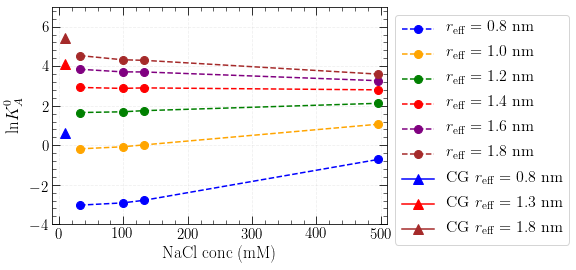

In [195]:
conc                 = [32.758, 98.836, 131.774, 496.163]
lnk_bulk_conc_08reff = [-3.02988721, -2.9175043,  -2.78791011, -0.71741881]
lnk_bulk_conc_10reff = [-0.18255056, -0.07909004,  0.01600165,  1.06361686]
lnk_bulk_conc_12reff = [1.65423571, 1.69048614, 1.7487387, 2.1212003]
lnk_bulk_conc_14reff = [2.9227812,  2.87557132, 2.90045623, 2.80172503]
lnk_bulk_conc_16reff = [3.84246254, 3.71127015, 3.70738526, 3.2658955]
lnk_bulk_conc_18reff = [4.53398793, 4.32415556, 4.29585868, 3.59685283]

fig = plt.figure() #figsize = [4., 4.]
ax  = fig.add_subplot(111)

plt.plot(conc, lnk_bulk_conc_08reff, marker = 'o', markersize = 8,\
         linestyle = '--', color = 'blue',\
         label = r"$\displaystyle r_{\rm eff} = 0.8$" ' nm')
plt.plot(conc, lnk_bulk_conc_10reff, marker = 'o', markersize = 8,\
         linestyle = '--', color = 'orange',\
         label = r"$\displaystyle r_{\rm eff} = 1.0$" ' nm')
plt.plot(conc, lnk_bulk_conc_12reff, marker = 'o', markersize = 8,\
         linestyle = '--', color = 'green',\
         label = r"$\displaystyle r_{\rm eff} = 1.2$" ' nm')
plt.plot(conc, lnk_bulk_conc_14reff, marker = 'o', markersize = 8,\
         linestyle = '--', color = 'red',\
         label = r"$\displaystyle r_{\rm eff} = 1.4$" ' nm')
plt.plot(conc, lnk_bulk_conc_16reff, marker = 'o', markersize = 8,\
         linestyle = '--', color = 'purple',\
         label = r"$\displaystyle r_{\rm eff} = 1.6$" ' nm')
plt.plot(conc, lnk_bulk_conc_18reff, marker = 'o', markersize = 8,\
         linestyle = '--', color = 'brown',\
         label = r"$\displaystyle r_{\rm eff} = 1.8$" ' nm')
plt.plot([10], [.62], marker = '^', markersize = 10,\
             color = 'blue', label = 'CG ' r"$\displaystyle r_{\rm eff} = 0.8$" ' nm')
plt.plot([10], [4.1], marker = '^', markersize = 10,\
             color = 'red', label = 'CG ' r"$\displaystyle r_{\rm eff} = 1.3$" ' nm')
plt.plot([10], [5.4], marker = '^', markersize = 10,\
             color = 'brown', label = 'CG ' r"$\displaystyle r_{\rm eff} = 1.8$" ' nm')

# Custom x axis
ax.tick_params(labelsize = 15)
plt.grid(True)
ax.tick_params(which = 'major', direction = 'in', length = 8, top = True, right = True)
ax.tick_params(which = 'minor', direction = 'in', length = 4, top = True, right = True)

ax.tick_params(labelsize = 15, grid_alpha = 0.2, grid_linestyle = '--')
ax.set_axisbelow(True)

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5)) 
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(AutoMinorLocator(5)) 

xlabel = r"NaCl conc (mM) "
ylabel = r"$\displaystyle {\rm ln}{K^0_A}$"
plt.xlabel(xlabel, fontsize = 17)
plt.ylabel(ylabel, fontsize = 17)
plt.legend(fontsize = 16, loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.axis([-10, 510, -4, 7])
plt.plot()

# Show graphic
#plt.show()
file_save_address = '/home/rohit/google-drive/magnesium/mg-netz/report-retreat/images-mg'
#plt.savefig(file_save_address + 'langmuir-manning1.png',\
            #bbox_inches = 'tight', dpi = 200)

'''
plt.plot(conc, theta_bulk_conc, marker = '^',\
         markersize = 10, linestyle = 'None')
plt.xlabel('NaCl conc (mM)')
plt.ylabel('theta')
plt.plot()
plt.show()
           
plt.plot(conc, zeta_, marker = 'v',\
         markersize = 10, linestyle = 'None')
plt.xlabel('NaCl conc (mM)')
plt.ylabel('zeta')
plt.plot()
plt.show()
'''

'''
K0_with_v0   = [1.2476959818147286, 6.402977664429093,\
                8.254664198187992, 2.410197086036613]
K0_without_v0 = [ 10.83405118942551, 27.09747679233088,\
                 30.393214245268286, 7.338979677407909]

plt.plot(conc, K0_without_v0) #K0_with_v0, conc,
'''

## McGhee-von Hippel model

In [ ]:
ka       = 1e3        # (mol/L)^-1
kb       = 5e3        # (mol/L)^-1
Nb       = 17
c0_a     = 4.1/1000   # mol/L
cd       = 0.032/1000 # mol/L
xb_max   = 60
number_of_points      = 100
xb_array = np.linspace(0.001, xb_max, number_of_points)
V0       = 1          # L
dHA      = 100         # kJ/mol
dHB      = 1000       # kL/mol

a        = kb*Nb
b        = 1/cd
c        = ka*Nb
xa       = c0_a/cd
d        = ka*xa

def mvh(p, xb):
    '''
    x, y, ca, cb = p  # x = \Theta_A(x) ; y = \Theta_B(x)
    F = np.empty((4))
    
    F[0] = ka*ca*(1-x-y) - x 
    F[1] = 4*kb*cb*(1-x-y)**2 - y*(2-y)
    F[2] = b*ca - xa + 2*Nb*x
    F[3] = b*cb - xb + Nb*y
    '''
    
    x, y = p  # x = \Theta_A(x) ; y = \Theta_B(x)
    F = np.empty((2))
    
    F[0] = a*y**3 + 2*a*x*y**2 + a*y*x**2 +\
           (-kb*xb - 2*a - 0.25*b)*y**2 + (-kb*xb)*x**2 +\
           (-2*kb*xb - 2*a)*x*y + (2*kb*xb + a + 0.5*b)*y + (2*kb*xb)*x + (-kb*xb)
    
    F[1] = 2*c*x**2 + 2*c*x*y + (-d - 2*c - b)*x + (-d)*y + d 
    
        
    return F
    
pGuess = np.array([1, .0])
#pGuess = np.array([1, .0, c0_a, xb_max*cd])

theta_a = []
theta_b = []

for i in range(number_of_points):
    z = fsolve(mvh, pGuess, args = (xb_array[i]))
    theta_a.append(z[0])
    theta_b.append(z[1])
    
plt.plot(xb_array, theta_a, xb_array, theta_b)
#plt.plot(theta_a, theta_b)
plt.show()

dQ = []

for i in range(1, n-1):
    
    dtheta_B = 0.5*( theta_b[i+1] - theta_b[i-1] )
    dtheta_A = 0.5*( theta_a[i+1] - theta_a[i-1] )
    
    dQ.append( Nb*cd*V0*(dHB*dtheta_B + 2*dHA*dtheta_A) )
    
plt.plot(xb_array[1:n-1], dQ)
plt.show()
print(theta_b[-1]*Nb, theta_a[-1]*2*Nb)

In [ ]:
'''
    y3  = np.power(y,3)
    xyy = np.multiply(x, np.power(y,2))
    xxy = np.multiply(np.power(x,2), y)
    xb_yy = np.multiply(xb, np.power(y,2))
    xb_xx = np.multiply(xb, np.power(x,2))
    xb_xy = np.multiply(xb, np.multiply(x, y))
    
    
    eq1 = a*y_3 + 2*a*xyy + a*xxy + (-kb)*xb_yy +\
          (-2*a - b)*np.power(y,2)+(-kb)*xb_xx + (-2*kb)*xb_xy
'''

In [ ]:
# numbers

N_na =   24 #8.65425            # 4.1819047     # bound Na+ ions
N_g   = 24                  # binding sites total
c_na = 0.13181982729990038  # mol/L ; 0.0793819 nm^-3
reff =   1.78               # 1.505      # nm
r_g  =   1.3778963802321125  #1.40               # bare radius of dPGS
z_g  = -1                   # charge on single binding site (sulfate group)
V_eff  = 4*np.pi/3*reff**3    # Donnan volume
v_d = 6.24                    # dPGS volume
V_g  =   4*np.pi/3*r_g**3   # bare dPGS volume
v_0  = 1                    # L/mol; standard volume 1.66 nm^3

sigma_mg = 0.263    # Mamatkulov, Netz MG(2) 
sigma_na = 0.258    # smith, Dang JCP 1993
sigma_cl = 0.440104 # smith, Dang JCP 1993

'''
sasa_vol = np.array([10.9033, 10.8731, 11.0969, 10.9603])
sasa_rd = [(3*vol/4/np.pi)**(1/3) for vol in sasa_vol]
print(np.average(sasa_rd), np.average(sasa_vol))
'''

## Std. one component Langmuir + Donnan for dPGS with monovalent salt

In [ ]:
theta_na = N_na / N_g
y        = -z_g*N_g/V_eff/c_na/2
exponent = y + np.sqrt(y**2 + 1)

rhs_langmuir = theta_na / (1 - theta_na) / c_na 

K_0_na_lang = rhs_langmuir / exponent / v_0

print(K_0_na_lang, theta_na)

In [ ]:
N_na/V_g*np.pi/6*sigma_na**3

## Excluded volume model (with negligible packing fraction of condensed counterions) + Donnan, for dPGS with monovalent salt

In [ ]:
v_na = 4*np.pi/3*sigma_na**3    # 2B_2 excluded volume of one Na+ ion

#theta_ev_na = v_na * N_na / (V_eff - v_d)
theta_ev_na = v_na * N_na / V_eff

rhs_ev = theta_ev_na / (1 - theta_ev_na) / c_na

K_0_na_ev = rhs_ev / exponent / v_0

print(K_0_na_ev, theta_ev_na)

## Excluded volume model + Donnan, for dPGS with monovalent salt

In [235]:
def DG_cs(x):
    rhs = (8*x - 9*x**2 + 3*x**3)*(1 - x)**(-3)
    return np.exp(-rhs)

In [ ]:
#eta_na = (N_na / V_eff) * np.pi/6 * sigma_na**3
eta_na = (N_na / (V_eff - V_g)) * np.pi/6 * sigma_na**3

v_na = 4*np.pi/3*sigma_na**3    # 2B_2 excluded volume of one Na+ ion



rhs_ev = theta_ev_na / DG_cs(eta_na) / c_na

K_0_na_ev = rhs_ev / exponent / v_0

print(K_0_na_ev, theta_ev_na)

In [ ]:
N = 34
cd = 0.05#np.linspace(0.00, 1, 50) #0.1/1000/1.66
c0 = np.linspace(0.00, 200, 50) #150/1000/1.66
V = 1

a = 1 - 2*c0/N/cd
b = cd*cd*V*V

x = (a*b + np.sqrt(a*a*b - b + 1))/(1 - b)

theta = 0.5*(x+1)
plt.plot(theta)
print(theta)

In [ ]:
x = np.linspace(0.1, 50, 1000)
N = 10
K = 5000
cd = 0.039/1000/1.66*10 
V0 = 1
dH = 6e7

z = 1 + x/N + 1/N/K/cd
sqt = np.sqrt( np.square(z) - 4*x/N )
theta = 0.5*(z - sqt)

dq = 0.5*dH*V0*cd*(1 - (z-2)/sqt)
plt.plot(x, dq)
print(np.round(x[-1]*cd*1.66*1000, 2), 'mM Mg2+')
# increasing dPGS concentration makes point of inflexion more evident

## Applying MVH model to CG simulations

In [9]:
sol_cg = bfunc.open_and_assign("cg_mg_conc_1_ka_-10_10_kb_-10_10.p")
    
dictionary = {'reff': sol_cg['reff'],    'error': sol_cg['error'],\
                      'ka'  : sol_cg['ka'],      'kb'   : sol_cg['kb'],\
                      'ta'  : sol_cg['theta_a'], 'tb'   : sol_cg['theta_b']}

df_1 = pd.DataFrame(dictionary)
df_1['conc'] = ['1mM']*7
df_1.set_index(['conc', 'reff'], inplace = True)
print(df_1)

              error          ka           kb        ta        tb
conc reff                                                       
1mM  1.3   0.036932   51.262961   179.037234  0.424880  0.187623
     1.4   0.083455   63.884613   278.053602  0.425167  0.187850
     1.5   0.089082   76.490656   398.614186  0.425190  0.187868
     1.6   0.061469   88.876132   538.153627  0.425074  0.187776
     1.7   0.067706  101.221244   698.038415  0.425102  0.187798
     1.8   0.046739  112.997273   869.905158  0.425000  0.187717
     1.9   0.101124  124.887547  1062.610868  0.425238  0.187906


In [10]:
sol_cg = bfunc.open_and_assign("cg_mg_conc_2_ka_-10_10_kb_-10_10.p")
    
dictionary = {'reff': sol_cg['reff'],    'error': sol_cg['error'],\
                      'ka'  : sol_cg['ka'],      'kb'   : sol_cg['kb'],\
                      'ta'  : sol_cg['theta_a'], 'tb'   : sol_cg['theta_b']}

df_2 = pd.DataFrame(dictionary)
df_2['conc'] = ['3mM']*7
df_2.set_index(['conc', 'reff'], inplace = True)
print(df_2)

              error          ka           kb        ta        tb
conc reff                                                       
3mM  1.3   0.114011   59.563533   440.558844  0.349767  0.331169
     1.4   0.048338   71.316917   631.579682  0.349914  0.331450
     1.5   0.006971   82.864654   852.671351  0.350032  0.331676
     1.6   0.067683   93.435245  1084.087878  0.349871  0.331367
     1.7   0.009936  104.305455  1351.005356  0.350041  0.331692
     1.8   0.011618  114.133485  1617.592719  0.349998  0.331611
     1.9   0.013049  123.644276  1898.414584  0.350048  0.331707


In [11]:
sol_cg     = bfunc.open_and_assign("cg_mg_conc_3_ka_-10_10_kb_-10_10.p")

dictionary = {'reff': sol_cg['reff'],    'error': sol_cg['error'],\
                      'ka'  : sol_cg['ka'],      'kb'   : sol_cg['kb'],\
                      'ta'  : sol_cg['theta_a'], 'tb'   : sol_cg['theta_b']}

df_3 = pd.DataFrame(dictionary)
df_3['conc'] = ['5mM']*7
df_3.set_index(['conc', 'reff'], inplace = True)
print(df_3)

              error          ka           kb        ta        tb
conc reff                                                       
5mM  1.3   0.056097   57.802297   600.762150  0.303885  0.406711
     1.4   0.056570   67.837053   827.458686  0.303923  0.406819
     1.5   0.063266   77.259786  1073.295654  0.303850  0.406611
     1.6   0.087597   86.248151  1337.555937  0.303788  0.406433
     1.7   0.056896   95.323716  1633.857970  0.303925  0.406826
     1.8   0.061351  103.267082  1917.503560  0.303857  0.406631
     1.9   0.074991  110.758669  2205.808582  0.303817  0.406516


In [12]:
sol_cg     = bfunc.open_and_assign("cg_mg_conc_4_ka_-10_10_kb_-10_10.p")

dictionary = {'reff': sol_cg['reff'],    'error': sol_cg['error'],\
                      'ka'  : sol_cg['ka'],      'kb'   : sol_cg['kb'],\
                      'ta'  : sol_cg['theta_a'], 'tb'   : sol_cg['theta_b']}

df_4 = pd.DataFrame(dictionary)
df_4['conc'] = ['10mM']*7
df_4.set_index(['conc', 'reff'], inplace = True)
print(df_4)

              error          ka           kb        ta        tb
conc reff                                                       
10mM 1.3   0.052475   76.490656  1337.555937  0.262358  0.511933
     1.4   0.036468   86.248151  1700.571006  0.262324  0.511781
     1.5   0.037617   95.323716  2077.289940  0.262289  0.511621
     1.6   0.057874  104.305455  2487.191534  0.262366  0.511972
     1.7   0.034788  111.872371  2861.151628  0.262300  0.511672
     1.8   0.067812  118.793738  3226.133111  0.262235  0.511380
     1.9   0.048740  126.143319  3637.673288  0.262352  0.511904


In [13]:
sol_cg     = bfunc.open_and_assign("cg_mg_conc_5_ka_-10_10_kb_-10_10.p")

dictionary = {'reff': sol_cg['reff'],    'error': sol_cg['error'],\
                      'ka'  : sol_cg['ka'],      'kb'   : sol_cg['kb'],\
                      'ta'  : sol_cg['theta_a'], 'tb'   : sol_cg['theta_b']}

df_5 = pd.DataFrame(dictionary)
df_5['conc'] = ['15mM']*7
df_5.set_index(['conc', 'reff'], inplace = True)
print(df_5)

              error          ka           kb        ta        tb
conc reff                                                       
15mM 1.3   0.057567   78.821326  1601.489391  0.237370  0.559675
     1.4   0.030901   87.991359  1995.798300  0.237399  0.559841
     1.5   0.031709   96.282217  2389.619542  0.237398  0.559836
     1.6   0.032724  104.305455  2804.468971  0.237462  0.560195
     1.7   0.042601  110.758669  3162.219757  0.237386  0.559767
     1.8   0.031021  117.611132  3565.606857  0.237460  0.560184
     1.9   0.061765  123.644276  3940.802138  0.237493  0.560376


In [14]:
df_all = pd.concat([df_1, df_2, df_3, df_4, df_5])

In [15]:
df_all.loc[('10mM', 1.9), :]

error       0.048740
ka        126.143319
kb       3637.673288
ta          0.262352
tb          0.511904
Name: (10mM, 1.9), dtype: float64

In [16]:
df_all.loc[('10mM', 1.9), 'kb']

3637.673288426113

In [17]:
df_all.loc[(['1mM', '10mM'], 1.3), :]

,,error,ka,kb,ta,tb
conc,reff,,,,,
1mM,1.3,0.036932,51.262961,179.037234,0.424880,0.187623
10mM,1.3,0.052475,76.490656,1337.555937,0.262358,0.511933


In [18]:
df_all.loc[(slice(None), 1.9), :]

,,error,ka,kb,ta,tb
conc,reff,,,,,
1mM,1.9,0.101124,124.887547,1062.610868,0.425238,0.187906
3mM,1.9,0.013049,123.644276,1898.414584,0.350048,0.331707
5mM,1.9,0.074991,110.758669,2205.808582,0.303817,0.406516
10mM,1.9,0.048740,126.143319,3637.673288,0.262352,0.511904
15mM,1.9,0.061765,123.644276,3940.802138,0.237493,0.560376


In [19]:
veff = 4*np.pi/3*(1.9**3)
-np.log(df_all.loc[(slice(None), 1.9), 'kb']/veff)

conc  reff
1mM   1.9    -3.610511
3mM   1.9    -4.190801
5mM   1.9    -4.340876
10mM  1.9    -4.841126
15mM  1.9    -4.921166
Name: kb, dtype: float64

In [40]:
datafile = "/home/rohit/google-drive/jupyter-notebooks/cg-g2-bound-counterions.csv"
cg_data = pd.read_csv(datafile, sep = ',', index_col = None,  engine = 'python')
cg_data.set_index('conc', inplace = True)
cg_data['theta_na'] = cg_data['na_bound']/24
cg_data['theta_mg'] = cg_data['mg_bound']/12
cg_data['mg_by_na'] = cg_data['mg_bound']/cg_data['na_bound']
print(cg_data)

      mg_bound  mg_total  na_bound  na_total  theta_na  theta_mg  mg_by_na
conc                                                                      
0         0.00         0      13.2      2438  0.550000  0.000000  0.000000
1         2.25        16      10.2      2438  0.425000  0.187500  0.220588
3         3.98        48       8.4      2438  0.350000  0.331667  0.473810
5         4.88        61       7.3      2438  0.304167  0.406667  0.668493
10        6.14       162       6.3      2438  0.262500  0.511667  0.974603
15        6.72       243       5.7      2438  0.237500  0.560000  1.178947


In [34]:
cg_conc_array = [1, 3, 5, 10, 15]

dtp = np.dtype([('conc' , np.float64),
                ('error', np.float64),
                ('b2_mg', np.float64),
                ('b2_na', np.float64),
                ('tpbmg'  , np.float64),
                ('tpbna'  , np.float64),
                ('tcgmg'  , np.float64),
                ('tcgna'  , np.float64)])

db = np.zeros(1, dtype = dtp)

for conc in cg_conc_array:

    sol = bfunc.open_and_assign('pb_cg_' + str(conc) + '_tol_0.25.p')

    #sol_min = sol[sol['error'] == np.min(sol['error'])]
    error = np.average(sol['error'])
    b2_mg = np.average(sol['b2'][:,0])
    b2_na = np.average(sol['b2'][:,1])
    tmg   = np.average(sol['theta'][:,0]*12)
    tna   = np.average(sol['theta'][:,1]*24)

    cg_theta  = np.array([cg_data.loc[conc]['mg_bound'],
                          cg_data.loc[conc]['na_bound']], dtype = np.float64)
    
    e = np.array([(conc, error, b2_mg, b2_na, tmg, tna, cg_theta[0], cg_theta[1])],
                 dtype = dtp)
    
    db = np.append(db, e)
    
db = np.delete(db, 0)

df = pd.DataFrame(db)
'''
plt.plot(df['tpbmg'], marker = 'o', linestyle = '--')
plt.plot(df['tcgmg'], marker = 'o', linestyle = '--')
plt.plot(df['tpbna'], marker = 's', linestyle = '--')
plt.plot(df['tcgna'], marker = 's', linestyle = '--')
'''

"\nplt.plot(df['tpbmg'], marker = 'o', linestyle = '--')\nplt.plot(df['tcgmg'], marker = 'o', linestyle = '--')\nplt.plot(df['tpbna'], marker = 's', linestyle = '--')\nplt.plot(df['tcgna'], marker = 's', linestyle = '--')\n"

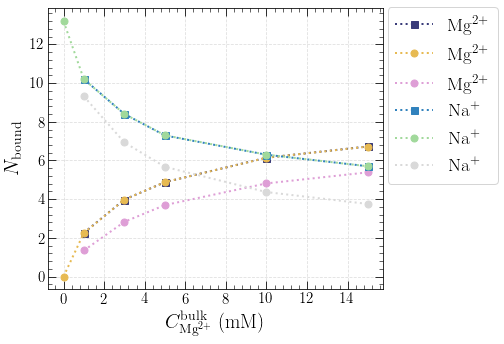

In [53]:
fig = plt.figure()
ax  = fig.add_subplot(111)

jet = plt.get_cmap('tab20b')
colors = iter(jet(np.linspace(0,1,3)))

plt.plot(cg_data.index[1:], 12*df_all.loc[(slice(None), 1.9), 'tb'],  marker = 's',\
         linewidth = 2, markersize = 7, color = next(colors), linestyle = ':',\
         label     = r"$\displaystyle {\rm Mg^{2+}}$")

plt.plot(cg_data.index, cg_data['mg_bound'], linestyle = ':', marker = 'o',\
         linewidth = 2, markersize = 7, color = next(colors),\
         label = r"$\displaystyle {\rm Mg^{2+}}$")

plt.plot(cg_data.index[1:], df['tpbmg'], linestyle = ':', marker = 'o',\
         linewidth = 2, markersize = 7, color = next(colors),\
         label = r"$\displaystyle {\rm Mg^{2+}}$")

jet = plt.get_cmap('tab20c')
colors = iter(jet(np.linspace(0,1,3)))

plt.plot(cg_data.index[1:], 24*df_all.loc[(slice(None), 1.9), 'ta'],  marker = 's',\
         linewidth = 2, markersize = 7, color = next(colors), linestyle = ':',\
         label     = r"$\displaystyle {\rm Na^{+}}$")

plt.plot(cg_data.index, cg_data['na_bound'], linestyle = ':', marker = 'o',\
         linewidth = 2, markersize = 7, color = next(colors),\
         label = r"$\displaystyle {\rm Na^{+}}$")

plt.plot(cg_data.index[1:], df['tpbna'], linestyle = ':', marker = 'o',\
         linewidth = 2, markersize = 7, color = next(colors),\
         label = r"$\displaystyle {\rm Na^{+}}$")

plotify(x_major_ticks   = 2, x_minor_ticks = 5,
        y_major_ticks   = 2, y_minor_ticks = 5,
        xname           = r"$\displaystyle C^{\rm bulk}_{\rm Mg^{2+}}$ (mM)",
        yname           = r"$\displaystyle N_{\rm bound}$",
        legend_location = (.87, 0.54, 0.5, 0.5))
            
plt.show()

In [ ]:
'''
plt.plot(cg_data['conc'], cg_data['mg_bound'], linestyle = '--', marker = 's',\
         linewidth = 3, markersize = 10, color = 'xkcd:red',\
         label = r"$\displaystyle {\rm Mg^{2+}}$")

plt.plot(cg_data['conc'], cg_data['na_bound'], linestyle = '--', marker = 's',\
         linewidth = 3, markersize = 10, color = 'xkcd:red',\
         label = r"$\displaystyle {\rm Na^{+}}$")
'''

In [5]:
def plotify(x_major_ticks   = 30, x_minor_ticks = 5,
            y_major_ticks   = 1 , y_minor_ticks = 5,
            xname           = r"$\displaystyle C_{{\rm Mg^{2+}},{\rm bulk}}$",
            yname           = r"$\displaystyle N_{{\rm Mg^{2+}},{\rm bound}}$",
            legend_location = (.98, 0.5, 0.5, 0.5),
            image_name       = 'new_plot.png',
            save            = False):
    
    plt.grid(True)
    
    ax.tick_params(which = 'major', direction = 'in',\
               length = 8, top = True, right = True)

    ax.tick_params(which = 'minor', direction = 'in',\
               length = 4, top = True, right = True)

    ax.tick_params(labelsize = 15, grid_alpha = 0.4, grid_linestyle = '--')

    ax.set_axisbelow(True)

    ax.xaxis.set_major_locator(MultipleLocator(x_major_ticks))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_ticks)) # for the minor ticks,
                                                # use no labels; default NullFormatter
    
    ax.yaxis.set_major_locator(MultipleLocator(y_major_ticks))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_ticks)) 

    xlabel, ylabel = xname, yname
    #xlabel = r"$\displaystyle C^{\rm bulk}_{\rm Mg^{2+}} / C^{\rm bulk}_{\rm Na^{+}}$"
    #ylabel = r"$\displaystyle N_{\rm Mg^{2+}} / N_{\rm Na^{+}}$"
    
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    
    
    font = {'family': 'serif',
            'color':  'xkcd:black',
            'weight': 'normal',
            'size': 25,
            }

    #plt.text(115, 2, r"$\displaystyle C_{{\rm Na^{+}},{\rm bulk}}$",fontdict=font)
    
    
    plt.legend(fontsize = 19, loc = 0, bbox_to_anchor = legend_location)
    plt.subplots_adjust(top = 1.1)
    
    if save is True:
        direc = '/home/rohit/google-drive/magnesium/mg-netz/images/'
        image_name = direc + image_name
        plt.savefig(image_name, bbox_inches = 'tight', dpi = 200)

## Applying MVH model to ITC 

In [3]:
sol = bfunc.open_and_assign("itc_mg_2_5mM_ka_-5_10_kb_-5_10.p")

In [157]:
'''
dh = pd.DataFrame({'reff': sol['reff'], 'dha': sol['dha'], 'dhb': sol['dhb'],\
                   'ka': sol['ka0'], 'kb': sol['kb0']})
'''

reff     = 1.9
dh       = dh[dh.reff == reff]
vol_dpgs = 4*np.pi/3*reff**3
print(sol['theta_a'])

'''
def rel_error(x, y):
    return np.abs(x-y)/x

dh = dh[rel_error(dh.kb, dh.ka) < 5]
#dh = dh[dh.ka < 10*vol_dpgs]
dh = dh[dh.kb < 10*vol_dpgs]
dh
'''

[[0.18602314 0.16409921 0.14762211 ... 0.07326389 0.07263453 0.07189621]
 [0.18933377 0.16745606 0.151001   ... 0.07573269 0.07508628 0.0743279 ]
 [0.19267686 0.17085533 0.15443039 ... 0.07827298 0.07760928 0.07683056]
 ...
 [0.61821793 0.58802517 0.56179387 ... 0.35660468 0.35421411 0.35134498]
 [0.62349033 0.59366113 0.56781814 ... 0.36502687 0.36262918 0.35975024]
 [0.62876698 0.59931215 0.57386575 ... 0.37353513 0.37113181 0.36824485]]


'\ndef rel_error(x, y):\n    return np.abs(x-y)/x\n\ndh = dh[rel_error(dh.kb, dh.ka) < 5]\n#dh = dh[dh.ka < 10*vol_dpgs]\ndh = dh[dh.kb < 10*vol_dpgs]\ndh\n'

In [95]:
sol['reff'][75430]

1.9

In [4]:
def ln(a):
    return np.log(a)

N = 34

def kappa(ca0, xb, cd):
    
    x = [i+2 for i in range(len(xb))]
    vol = np.array([1.43 + i*8e-3 for i in x])
    
    ca0 = ca0*std_volume/1000
    cb0 = np.array([i*cd*1.43 for i in xb])/vol
    ccl = 2*cb0 + ca0
    I   = 2*cb0 + ca0 + ccl
    return np.sqrt(8 * np.pi * .7 * I ), cb0

    

def energy(theta_a, theta_b, xb, reff, ca0, cd, ka0, kb0):
    
    cd     *= std_volume/1000
    k, cb0  = kappa(ca0, xb, cd)
    t       = np.square(1-theta_a-theta_b)
    elec    = N**2*.7/(2*reff*(1+k*reff))*t
    
    A = -    N*theta_a*(ln(ka0*(ca0 - cd*N*theta_a)/(N*theta_a)) )
    B = -0.5*N*theta_b*(ln(kb0*(cb0 - 0.5*cd*N*theta_b)/(0.5*N*theta_b)) )
    C = A+B
    
    MVH = -N*(1-.5*theta_b)*ln(1-.5*theta_b) + .5*N*theta_b*ln(.5*theta_b)\
           + N*theta_a*ln(theta_a) + N*(1-theta_a-theta_b)*ln(1-theta_a-theta_b)
    
    return {'e':elec, 's': C, 'm': MVH}

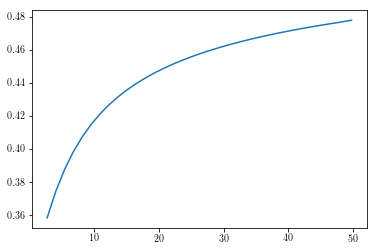

In [22]:
y = sol[77935]

plt.plot(xb_2_5mM, y['theta_a']+y['theta_b'])


# d = energy(y['theta_a'], y['theta_b'], xb_2_5mM, y['reff'],\
#              4, .0638, y['ka0'], y['kb0'] )
# '''
# plt.plot(xb_2_5mM, d['e'], label = 'elec')
# plt.plot(xb_2_5mM, d['s'], label = 'cr')
# plt.plot(xb_2_5mM, d['m'], label = 'mvh')
# plt.plot(xb_2_5mM, d['e'] + d['s']+d['m'], label = 'tot')
# '''
# plt.plot(xb_2_5mM, d['e'], xb_2_5mM, d['s'], xb_2_5mM, d['m'])
# #plt.plot(xb_2_5mM, 34*y['theta_a'], xb_2_5mM, 17*y['theta_b'])
# #plt.legend()
# plt.show()

In [26]:
a = np.array([[1, 2, 3], [1, 4, 7]])
a[-1]

array([1, 4, 7])

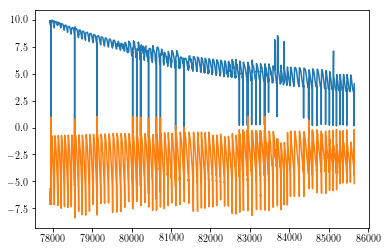

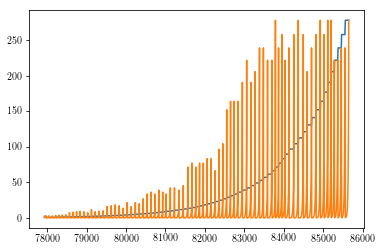

In [71]:
plt.plot(dh['dhb'])
plt.plot(dh['dha'])
plt.show()
plt.plot(dh['kb'])
plt.plot(dh['ka'])
plt.show()

10


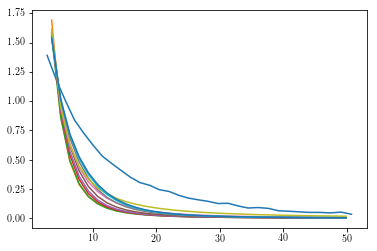

In [106]:
ll = np.arange(0, 10000, 1000)
print(len(ll))

plt.plot(xb_0_8mM, q_0_8mM_per_mg)

for i in ll:
    
     plt.plot(running_avg(xb_0_8mM), sol['q_per_mg'][i])

In [209]:
sol = bfunc.open_and_assign("itc_mg_2_5mM_ka_-5_10_kb_-5_10.p_tol_0.001")

In [27]:
dh = pd.DataFrame({'reff': sol['reff'], 'dha': sol['dha'], 'dhb': sol['dhb'],\
                   'ka': sol['ka0'], 'kb': sol['kb0']})
dh.describe()

,reff,dha,dhb,ka,kb
count,89947.000000,89947.000000,89947.000000,89947.000000,89947.000000
mean,1.625428,-4.699450,5.578787,1346.700616,1143.623425
std,0.194369,2.132598,1.985212,3426.693887,3023.138129
min,1.300000,-9.999898,-3.589359,0.006738,0.006738
25%,1.500000,-6.078329,3.924810,0.668974,1.222631
50%,1.600000,-4.415430,5.422899,28.986615,23.120127
75%,1.800000,-3.571977,7.075600,687.226077,548.141060
max,1.900000,9.979541,9.999620,22026.465795,22026.465795


24


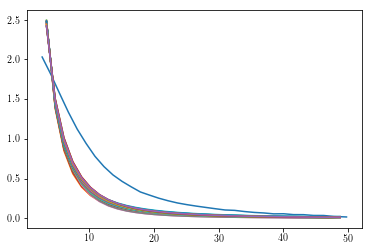

In [215]:
ll = np.arange(0, 23963, 1000)
print(len(ll))

plt.plot(xb_2_5mM, q_2_5mM_per_mg)

for i in ll:
    
     plt.plot(running_avg(xb_2_5mM), sol['q_per_mg'][i])